In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('VKR_docs_structure.csv')
df = df.sample(len(df))
print(len(df))
df.head()

359


,title,text_paper,dict_sections_texts,faculty_department,faculty,department,degree,main_preproc_text,introduction,contents,conclusion,TZ
190,Автоматизация процесса проверки билетов на мер...,"['Выпускная Квалификационная Работа', 'Автомат...","{'выпускная квалификационная работа': '', 'авт...","['ФИТиП', 'ИС']",ФИТиП,ИС,bachelor,автор санников александр дмитриевич фамилия им...,Компания Ооо Тинькофф Центр Разработки российс...,Термины И Определения Введение Глава. Описание...,В данной работе был произведн анализ и моделир...,NONE
301,Разработка модуля «Доменный регистратор» для с...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФИТиП', 'ИС']",ФИТиП,ИС,bachelor,разработка модуль доменный регистратор сервис ...,В настоящее время достаточно свободной нишей д...,Анализ технических взаимодействий с системой р...,В данной работы представлен отчт о проектирова...,NONE
77,Разработка мобильного приложения для защищенно...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФБИТ', 'ПБКС']",ФБИТ,ПБКС,bachelor,национальный исследовательский университет итм...,Интернет это революционное изобретение которое...,Анализ Предметной Области Перечень Угроз Для С...,Интернет вещей концепция используемая в систем...,NONE
315,Разработка плагина для Confluence Банк провер...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФИТиП', 'ИС']",ФИТиП,ИС,bachelor,федеральный государственный автономный образов...,Процесс обмена полезной информацией всегда был...,.. Анализ прикладного процесса и построение ав...,Целью данной работы была разработка плагина дл...,NONE
240,Разработка автоматизированной системы построен...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФИТиП', 'ИС']",ФИТиП,ИС,bachelor,автор малинин александр сергеевич фамилия имя ...,NONE,NONE,NONE,NONE


In [3]:
le_department = LabelEncoder() 
df['department_label'] = le_department.fit_transform(df['department'])

le_faculty = LabelEncoder() 
df['faculty_label'] = le_faculty.fit_transform(df['faculty'])

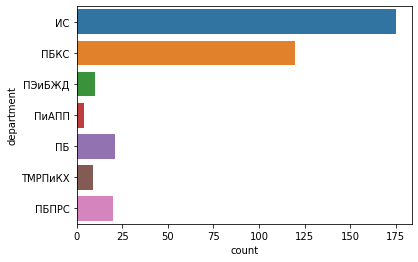

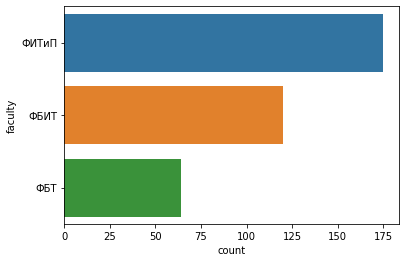

In [4]:
sns.countplot(y = df['department'])
plt.show()

sns.countplot(y = df['faculty'])
plt.show()

### Departments

train


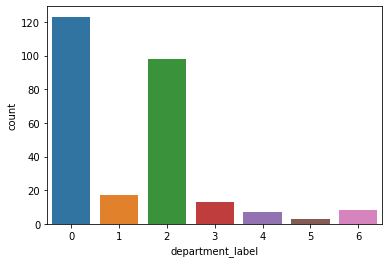

test


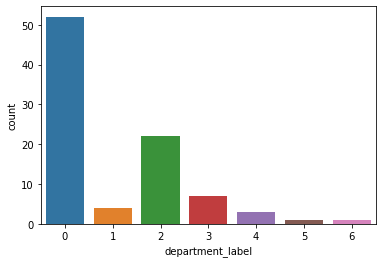

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', LogisticRegression(C=7, random_state=0))])
accuracy: 0.9666666666666667


              precision    recall  f1-score   support

          ИС       0.98      1.00      0.99        52
          ПБ       1.00      1.00      1.00         4
        ПБКС       0.96      1.00      0.98        22
       ПБПРС       0.88      1.00      0.93         7
      ПЭиБЖД       1.00      0.67      0.80         3
       ПиАПП       0.00      0.00      0.00         1
     ТМРПиКХ       0.00      0.00      0.00         1

    accuracy                           0.97        90
   macro avg       0.69      0.67      0.67        90
weighted avg       0.95      0.97      0.95        90

Wall time: 4min 33s


Pipeline(steps=[('vect', TfidfVectorizer()),
                ('model', LogisticRegression(C=7, random_state=0))])

In [5]:
%%time
X = df['main_preproc_text']
y = df['department_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=10)

print('train')
sns.countplot(y_train)
plt.show()

print('test')
sns.countplot(y_test)
plt.show()

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model',LogisticRegression(random_state = 0))])

params={'model__C':np.arange(10),
        'model__penalty':['l1','l2', 'elasticnet'], 
        'model__solver':['liblinear','lbfgs'],
        'vect__use_idf':[True, False],
        'vect__norm':['l1', 'l2']}

grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params)
grid.fit(X_train, y_train)
model_best_department = grid.best_estimator_
print(model_best_department)

predicted_department = model_best_department.predict(X_test)
print('accuracy:', metrics.accuracy_score(predicted_department, y_test))
print('\n')
print(metrics.classification_report(y_test, predicted_department, target_names=le_department.classes_))
model_best_department.fit(X, y)

In [6]:
fi_department = pd.DataFrame(model_best_department.named_steps['model'].coef_.T)
fi_department = fi_department.rename(\
                columns={c:'coef_' + le_department.inverse_transform([int(c)])[0] for c in fi_department.columns})
fi_department.index = model_best_department.named_steps['vect'].get_feature_names()
fi_department = fi_department.sort_values(by = list(fi_department.columns), ascending =False)
print(len(fi_department))
fi_department.head(10)

45320


,coef_ИС,coef_ПБ,coef_ПБКС,coef_ПБПРС,coef_ПЭиБЖД,coef_ПиАПП,coef_ТМРПиКХ
модуль,1.818011,-0.181336,-0.971247,-0.204374,-0.187484,-0.103168,-0.170401
запрос,1.731487,-0.161419,-0.911876,-0.210229,-0.188975,-0.095641,-0.163347
требование,1.725185,0.034178,-0.941186,-0.310496,-0.212499,-0.120939,-0.174244
класс,1.617785,-0.193177,-0.786182,-0.238449,-0.131813,-0.115677,-0.152488
заявка,1.538451,-0.162789,-0.765290,-0.196041,-0.175144,-0.090140,-0.149047
архитектура,1.476571,-0.132767,-0.815555,-0.168985,-0.152070,-0.078638,-0.128556
работа,1.457737,-0.299757,0.024113,-0.359015,-0.177447,-0.212391,-0.433241
компонент,1.407970,-0.015062,-0.931998,-0.160468,-0.165357,-0.104911,-0.030174
система,1.370815,-0.391994,1.043292,-0.766999,-0.526353,-0.301014,-0.427746
модель,1.305303,-0.226292,-0.258758,-0.266800,-0.217727,-0.125529,-0.210198


In [7]:
# Наиболее значимые слова для направлений
fi_department_keys = []
for col in fi_department.columns:
    fi_department_col = fi_department[col].sort_values(ascending =False)[:15]
    department_keywords = fi_department_col.index.values
    fi_department_keys.append({'department':col.split('_')[1], 'keywords':department_keywords})
    print(col)
    print(fi_department_col)
    print('\n')

fi_department_keys = pd.DataFrame(fi_department_keys)
fi_department_keys.to_csv('department_keywords.csv', index = False)  
fi_department_keys

coef_ИС
модуль         1.818011
запрос         1.731487
требование     1.725185
класс          1.617785
заявка         1.538451
архитектура    1.476571
работа         1.457737
компонент      1.407970
система        1.370815
модель         1.305303
приложение     1.300198
процесс        1.267244
клиент         1.235760
заказ          1.170815
страница       1.162925
Name: coef_ИС, dtype: float64


coef_ПБ
молоко           2.840763
сыр              1.905598
ряска            1.701263
молочный         1.610894
продукт          1.378689
белок            1.197970
производство     1.182842
чайный           1.129741
гриб             1.102849
масса            1.091095
кисломолочный    1.040540
температура      1.034252
напиток          0.920108
сыворотка        0.905528
батончик         0.892282
Name: coef_ПБ, dtype: float64


coef_ПБКС
безопасность      2.692344
защита            2.500574
алгоритм          2.458173
информация        2.176077
атака             1.922467
уязвимость        1.89092

,department,keywords
0,ИС,"[модуль, запрос, требование, класс, заявка, ар..."
1,ПБ,"[молоко, сыр, ряска, молочный, продукт, белок,..."
2,ПБКС,"[безопасность, защита, алгоритм, информация, а..."
3,ПБПРС,"[напиток, сок, дрожжи, клетка, раствор, чай, х..."
4,ПЭиБЖД,"[отход, нефть, газ, вода, нефтепродукт, выброс..."
5,ПиАПП,"[пиво, колбаса, хлеб, ржаной, колбасный, произ..."
6,ТМРПиКХ,"[рыба, масло, шоколад, оливковый, собака, лако..."


### Faculties

train


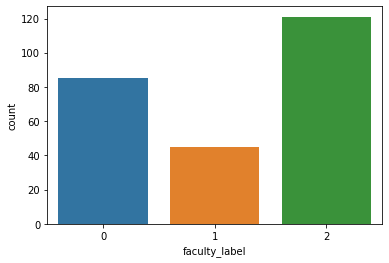

test


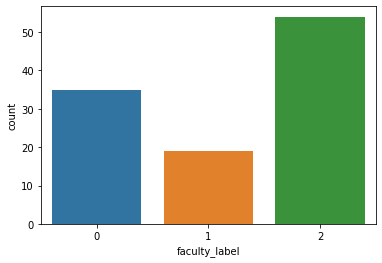

Pipeline(steps=[('vect', TfidfVectorizer(use_idf=False)),
                ('model', LogisticRegression(C=5, random_state=0))])
accuracy: 0.9907407407407407


              precision    recall  f1-score   support

        ФБИТ       1.00      0.97      0.99        35
         ФБТ       1.00      1.00      1.00        19
       ФИТиП       0.98      1.00      0.99        54

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108

Wall time: 3min 16s


In [10]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df['main_preproc_text'], df['faculty_label'], 
                                                    test_size=0.3, random_state=100)

print('train')
sns.countplot(y_train)
plt.show()

print('test')
sns.countplot(y_test)
plt.show()


pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model',LogisticRegression(random_state = 0))])

params={'model__C':np.arange(10),
        'model__penalty':['l1','l2', 'elasticnet'], 
        'model__solver':['liblinear','lbfgs'],
        'vect__use_idf':[True, False],
        'vect__norm':['l1', 'l2']}

grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params)
grid.fit(X_train, y_train)
model_best_faculty = grid.best_estimator_
print(model_best_faculty)

predicted_faculty = model_best_faculty.predict(X_test)
print('accuracy:', metrics.accuracy_score(predicted_faculty, y_test))
print('\n')
print(metrics.classification_report(y_test, predicted_faculty, target_names=le_faculty.classes_))

In [11]:
fi_faculty = pd.DataFrame(model_best_faculty.named_steps['model'].coef_.T)
fi_faculty = fi_faculty.rename(\
                columns={c:'coef_' + le_faculty.inverse_transform([int(c)])[0] for c in fi_faculty.columns})
fi_faculty.index = model_best_faculty.named_steps['vect'].get_feature_names()
fi_faculty= fi_faculty.sort_values(by = list(fi_faculty.columns), ascending =False)
print(len(fi_faculty))
fi_faculty.head(10)

35713


,coef_ФБИТ,coef_ФБТ,coef_ФИТиП
безопасность,2.291344,-0.411678,-1.879666
защита,2.116129,-0.520913,-1.595216
информация,1.791240,-1.138603,-0.652638
доступ,1.626112,-0.458302,-1.167809
алгоритм,1.516359,-0.683176,-0.833183
анализ,1.481181,-0.300761,-1.180420
обеспечение,1.271338,-0.304646,-0.966692
информационный,1.213774,-0.751842,-0.461932
устройство,1.182154,-0.328211,-0.853943
сеть,1.160459,-0.391006,-0.769453


In [12]:
# Наиболее значимые слова для факультетов
fi_faculty_keys = []
for col in fi_faculty.columns:
    fi_faculty_col = fi_faculty[col].sort_values(ascending =False)[:15]
    faculty_keywords = fi_faculty_col.index.values
    fi_faculty_keys.append({'faculty':col.split('_')[1], 'keywords':faculty_keywords})
    print(col)
    print(fi_faculty_col)
    print('\n')

fi_faculty_keys = pd.DataFrame(fi_faculty_keys)
fi_faculty_keys.to_csv('faculty_keywords.csv', index = False)  
fi_faculty_keys

coef_ФБИТ
безопасность      2.291344
защита            2.116129
информация        1.791240
доступ            1.626112
алгоритм          1.516359
анализ            1.481181
обеспечение       1.271338
информационный    1.213774
устройство        1.182154
сеть              1.160459
атака             1.090847
ключ              1.002336
уязвимость        0.987488
двигатель         0.913304
разработать       0.910376
Name: coef_ФБИТ, dtype: float64


coef_ФБТ
производство    1.582761
вода            1.529989
продукт         1.518250
отход           1.053895
напиток         1.044671
вещество        0.935463
пищевой         0.927519
сырьё           0.904472
молоко          0.808610
температура     0.799054
содержание      0.780314
показатель      0.715533
кислота         0.704144
клетка          0.676058
исследование    0.670138
Name: coef_ФБТ, dtype: float64


coef_ФИТиП
требование     1.741096
модель         1.369153
модуль         1.368995
компонент      1.265613
работа         1.262120
зап

,faculty,keywords
0,ФБИТ,"[безопасность, защита, информация, доступ, алг..."
1,ФБТ,"[производство, вода, продукт, отход, напиток, ..."
2,ФИТиП,"[требование, модель, модуль, компонент, работа..."
